### 1. Libraries Import

In [1]:
import os, json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.datasets import make_regression
sns.set()
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
import statsmodels.api as sm

### 2. Data Import

In [2]:
datadir = "../data"
outdir = "../output_reports"
outdir_graph = "../figures"
data = os.path.join(datadir, "NSDUH_2023_Tab.txt")

variables_used = [
    # Survey design variables 
    "ANALWT2_C", "VESTR_C", "VEREP",
    # Primary outcomes
    "SUTRTPY", "MHTRTPY",
    # Secondary (telehealth) outcomes
    "TELEAPTYR", "IRSUTPHVID", "IRMHTPHVID",
    # Demographic predictors
    "CATAG6", "IRSEX", "NEWRACE2",
    # Socioeconomic predictors
    "IRMARIT", "IREDUHIGHST2", "IRWRKSTAT18",
    "IRINSUR4", "INCOME",
    # Clinical severity predictors
    "IRPYUD5ALC", "IRPYUD5MRJ", "KSSLR6YR", "IRAMDEYR",
    # Behavioral predictors
    "IRALCFY", "IRMJFY", "ILLYR",
    # Risk perception predictors
    "RSKCIGPKD", "RSKMRJWK"
]

df_og = pd.read_csv(data, sep = "\t", usecols = variables_used, dtype=str)

#export_path = os.path.join(datadir, "NSDUH_2023_subset_raw.csv")
#df_og.to_csv(export_path, index=False)

### 3. Data Cleaning & Remapping

In [3]:
# Simple yes/no in 0/1 form
binary_map_01 = {"0": "No", "1": "Yes"}

# Age (CATAG6)
age_map = {
    "1": "12-17",
    "2": "18-25",
    "3": "26-34",
    "4": "35-49",
    "5": "50-64",
    "6": "65+"
}

# Sex at birth (IRSEX)
sex_map = {"1":"Male","2":"Female"}

race_map = {
    "1": "Non-Hispanic White",
    "2": "Non-Hispanic Black/African American",
    "3": "Non-Hispanic Native American/Alaska Native",
    "4": "Non-Hispanic Native Hawaiian/Other Pacific Islander",
    "5": "Non-Hispanic Asian",
    "6": "Non-Hispanic more than one race",
    "7": "Hispanic"
}

# Family income (INCOME)
income_map = {
    "1":"< $20,000",
    "2":"$20,000-$49,999",
    "3":"$50,000-$74,999",
    "4":"$75,000+"
}

df = df_og.copy()

# Convert survey design variables to numeric
df["ANALWT2_C"] = pd.to_numeric(df["ANALWT2_C"], errors="coerce")
df["VESTR_C"]   = pd.to_numeric(df["VESTR_C"], errors="coerce")
df["VEREP"]     = pd.to_numeric(df["VEREP"], errors="coerce")

df["SUTRTPY_lbl"] = df["SUTRTPY"].map(binary_map_01)
# Convert to numeric for modeling
df["SUTRTPY"] = pd.to_numeric(df["SUTRTPY"], errors="coerce")

df["MHTRTPY_lbl"] = df["MHTRTPY"].map(binary_map_01)
# Convert to numeric for modeling
df["MHTRTPY"] = pd.to_numeric(df["MHTRTPY"], errors="coerce")

# Create a labeled version
df["TELEAPTYR_lbl"] = df["TELEAPTYR"].map({
    "1": "Yes",
    "2": "No",
    "85": "Bad data",
    "94": "Don't know",
    "97": "Refused",
    "98": "Blank"
})

# Convert to numeric (1 = Yes, 0 = No, NaN for all nonresponse codes)
df["TELEAPTYR"] = df["TELEAPTYR"].replace({
    "1": 1,
    "2": 0,
    "85": np.nan,
    "94": np.nan,
    "97": np.nan,
    "98": np.nan
}).astype("float")

df["IRSUTPHVID_lbl"] = df["IRSUTPHVID"].map(binary_map_01)
df["IRSUTPHVID"] = pd.to_numeric(df["IRSUTPHVID"], errors="coerce")

df["IRMHTPHVID_lbl"] = df["IRMHTPHVID"].map(binary_map_01)
df["IRMHTPHVID"] = pd.to_numeric(df["IRMHTPHVID"], errors="coerce")

df["CATAG6_lbl"] = df["CATAG6"].map(age_map)
df["CATAG6"] = pd.to_numeric(df["CATAG6"], errors="coerce")

df["IRSEX_lbl"] = df["IRSEX"].map(sex_map)
df["IRSEX"] = pd.to_numeric(df["IRSEX"], errors="coerce")

df["NEWRACE2_lbl"] = df["NEWRACE2"].map(race_map)
df["NEWRACE2"] = pd.to_numeric(df["NEWRACE2"], errors="coerce")

# Create a labeled version
df["IRMARIT_lbl"] = df["IRMARIT"].map({
    "1": "Married",
    "2": "Widowed",
    "3": "Divorced or Separated",
    "4": "Never Been Married",
    "99": "Legitimate skip (<=14 years old)"
})

# Convert to numeric, set skip to NaN
df["IRMARIT"] = df["IRMARIT"].replace({
    "1": 1,
    "2": 2,
    "3": 3,
    "4": 4,
    "99": np.nan
}).astype("float")

# Create a labeled version
df["IREDUHIGHST2_lbl"] = df["IREDUHIGHST2"].map({
    "1": "Fifth grade or less",
    "2": "Sixth grade",
    "3": "Seventh grade",
    "4": "Eighth grade",
    "5": "Ninth grade",
    "6": "Tenth grade",
    "7": "Eleventh or Twelfth grade, no diploma",
    "8": "High school diploma/GED",
    "9": "Some college credit, no degree",
    "10": "Associate's degree (AA, AS)",
    "11": "College graduate or higher"
})

# Convert to numeric (ordinal: 1–11)
df["IREDUHIGHST2"] = pd.to_numeric(df["IREDUHIGHST2"], errors="coerce")

# Create a labeled version
df["IRWRKSTAT18_lbl"] = df["IRWRKSTAT18"].map({
    "1": "Employed full time",
    "2": "Employed part time",
    "3": "Unemployed",
    "4": "Other (not in labor force)",
    "99": "Legitimate skip (age 12–14)"
})

# Convert to numeric (1–4), recode 99 to NaN
df["IRWRKSTAT18"] = df["IRWRKSTAT18"].replace({
    "1": 1,
    "2": 2,
    "3": 3,
    "4": 4,
    "99": np.nan
}).astype("float")

df["IRINSUR4_lbl"] = df["IRINSUR4"].map({
    "1": "Yes, covered by health insurance",
    "2": "No, not covered by health insurance"
})

# Convert to numeric (1 = Yes, 0 = No)
df["IRINSUR4"] = df["IRINSUR4"].replace({
    "1": 1,
    "2": 0
}).astype("float")

df["INCOME_lbl"] = df["INCOME"].map(income_map)
df["INCOME"] = pd.to_numeric(df["INCOME"], errors="coerce")

# Convert to numeric (1–3), set '.' (college dorm) to NaN

df["IRPYUD5ALC_lbl"] = df["IRPYUD5ALC"].map(binary_map_01)
df["IRPYUD5ALC"] = pd.to_numeric(df["IRPYUD5ALC"], errors="coerce")

df["IRPYUD5MRJ_lbl"] = df["IRPYUD5MRJ"].map(binary_map_01)
df["IRPYUD5MRJ"] = pd.to_numeric(df["IRPYUD5MRJ"], errors="coerce")

df["KSSLR6YR"] = pd.to_numeric(df["KSSLR6YR"], errors="coerce")
# Ensure values outside 0–24 are treated as missing (paranoid safety)
df.loc[~df["KSSLR6YR"].between(0, 24, inclusive="both"), "KSSLR6YR"] = np.nan

df["IRAMDEYR_lbl"] = df["IRAMDEYR"].map({
    "0": "No",
    "1": "Yes",
    ".": "Not applicable (aged 12–17)"
})

# Convert to numeric (1 = Yes, 0 = No, NaN = not applicable)
df["IRAMDEYR"] = df["IRAMDEYR"].replace({
    "0": 0,
    "1": 1,
    ".": np.nan
}).astype("float")

# Create a labeled version
df["IRALCFY_lbl"] = df["IRALCFY"].map({
    "991": "Never used alcohol",
    "993": "No past-year use"
})

# Convert to numeric, treating 991 and 993 as 0 (no use), others keep their day counts
df["IRALCFY"] = df["IRALCFY"].replace({
    "991": 0,
    "993": 0
})
df["IRALCFY"] = pd.to_numeric(df["IRALCFY"], errors="coerce")

# Create a labeled version
df["IRMJFY_lbl"] = df["IRMJFY"].map({
    "991": "Never used marijuana",
    "993": "No past-year use"
})

# Convert to numeric, treating 991 and 993 as 0 (no use), others keep their day counts
df["IRMJFY"] = df["IRMJFY"].replace({
    "991": 0,
    "993": 0
})
df["IRMJFY"] = pd.to_numeric(df["IRMJFY"], errors="coerce")

# Create a labeled version
df["ILLYR_lbl"] = df["ILLYR"].map({
    "0": "Did not use in past year",
    "1": "Used in past year"
})

# Convert to numeric (binary: 0/1)
df["ILLYR"] = df["ILLYR"].replace({
    "0": 0,
    "1": 1
}).astype("float")

# Create a labeled version
df["RSKCIGPKD_lbl"] = df["RSKCIGPKD"].map({
    "1": "No risk",
    "2": "Slight risk",
    "3": "Moderate risk",
    "4": "Great risk",
    "85": "Bad data",
    "94": "Don't know",
    "97": "Refused",
    "98": "Blank"
})

# Convert to numeric (ordinal 1–4), set nonresponse codes to NaN
df["RSKCIGPKD"] = df["RSKCIGPKD"].replace({
    "1": 1,
    "2": 2,
    "3": 3,
    "4": 4,
    "85": np.nan,
    "94": np.nan,
    "97": np.nan,
    "98": np.nan
}).astype("float")

# Create a labeled version
df["RSKMRJWK_lbl"] = df["RSKMRJWK"].map({
    "1": "No risk",
    "2": "Slight risk",
    "3": "Moderate risk",
    "4": "Great risk",
    "85": "Bad data",
    "94": "Don't know",
    "97": "Refused",
    "98": "Blank"
})

# Convert to numeric (ordinal 1–4), set nonresponse codes to NaN
df["RSKMRJWK"] = df["RSKMRJWK"].replace({
    "1": 1,
    "2": 2,
    "3": 3,
    "4": 4,
    "85": np.nan,
    "94": np.nan,
    "97": np.nan,
    "98": np.nan
}).astype("float")

C:\Users\Admin\AppData\Local\Temp\ipykernel_36220\2803965217.py:61: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["TELEAPTYR"] = df["TELEAPTYR"].replace({
C:\Users\Admin\AppData\Local\Temp\ipykernel_36220\2803965217.py:95: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["IRMARIT"] = df["IRMARIT"].replace({
C:\Users\Admin\AppData\Local\Temp\ipykernel_36220\2803965217.py:131: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result

### 4. Data Analysis

#### 4.1. LASSO Logistic Regression Model for SUTRTPY

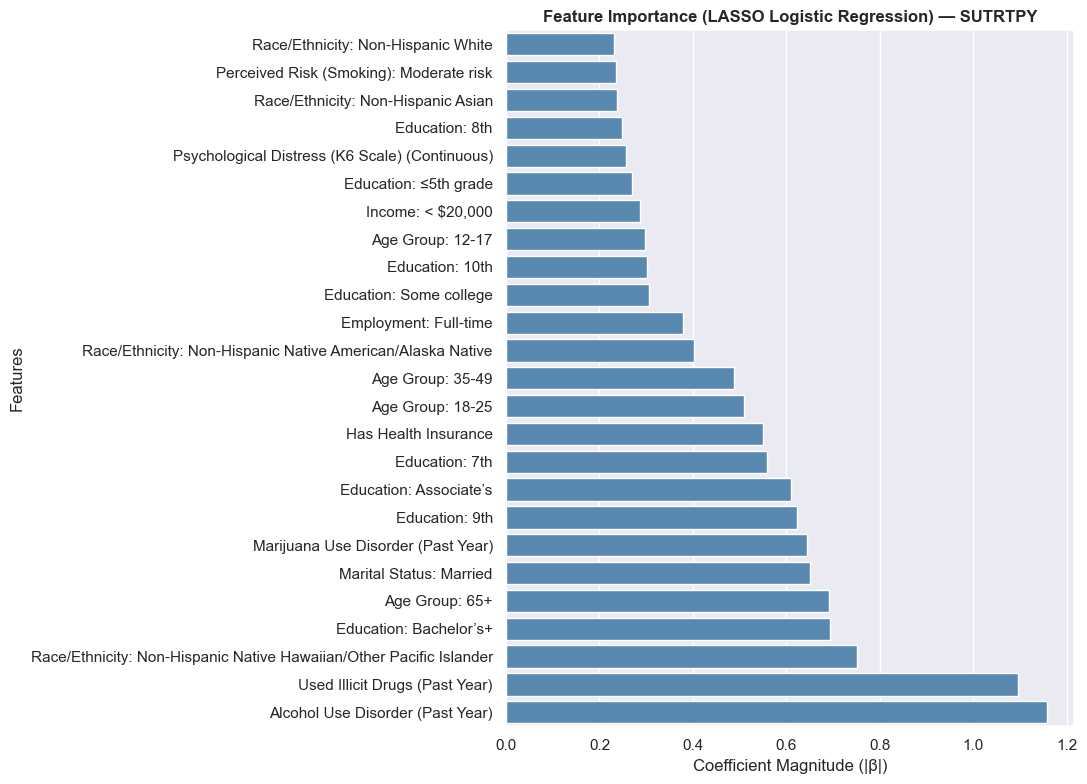

Saved: ../output_reports\SUTRTPY/lasso_output\lasso_SUTRTPY_feature_importance.png


In [ ]:
# ====== Pretty label helper ======
# Uses your existing maps: age_map, sex_map, race_map, income_map
def prettify_feature_labels(feature_like):
    """
    Accepts a pandas Series (or index) of feature names like:
      'NEWRACE2_2.0', 'IRINSUR4_1.0', 'KSSLR6YR', 'const'
    Returns a list of human-readable labels for plotting.
    """
    # Local dictionaries for variables not already provided above
    marital_map = {"1":"Married","2":"Widowed","3":"Divorced/Separated","4":"Never Married"}
    edu_map = {
        "1":"≤5th grade","2":"6th","3":"7th","4":"8th","5":"9th","6":"10th",
        "7":"11–12 (no diploma)","8":"High school/GED","9":"Some college",
        "10":"Associate’s","11":"Bachelor’s+"
    }
    work_map = {"1":"Full-time","2":"Part-time","3":"Unemployed","4":"Not in labor force"}
    pov_map  = {"1":"Below poverty","2":"≤2× threshold","3":">2× threshold"}
    risk_map = {"1":"No risk","2":"Slight risk","3":"Moderate risk","4":"Great risk"}

    # Vars treated as continuous
    continuous_vars = {"KSSLR6YR", "IRALCFY", "IRMJFY"}

    # Binary “positive” phrasing for nicer labels
    binary_positive = {
        "IRINSUR4": "Has Health Insurance",
        "ILLYR": "Used Illicit Drugs (Past Year)",
        "IRPYUD5ALC": "Alcohol Use Disorder (Past Year)",
        "IRPYUD5MRJ": "Marijuana Use Disorder (Past Year)",
    }

    out = []
    for raw in list(feature_like):
        f = str(raw)

        if f == "const":
            out.append("Intercept")
            continue

        # Split base and level (for dummies)
        if "_" in f:
            base, lvl = f.split("_", 1)
            lvl = lvl.replace(".0", "")  # clean OneHot suffix
        else:
            base, lvl = f, None

        # Build human label
        if base in continuous_vars:
            # Continuous vars (no levels)
            base_label = {
                "KSSLR6YR": "Psychological Distress (K6 Scale)",
                "IRALCFY": "Alcohol Use Days (Past Year)",
                "IRMJFY": "Marijuana Use Days (Past Year)"
            }.get(base, base)
            label = f"{base_label} (Continuous)"

        elif base == "CATAG6":
            label = f"Age Group: {age_map.get(lvl, lvl)}"
        elif base == "IRSEX":
            label = f"Sex: {sex_map.get(lvl, lvl)}"
        elif base == "NEWRACE2":
            label = f"Race/Ethnicity: {race_map.get(lvl, lvl)}"
        elif base == "INCOME":
            label = f"Income: {income_map.get(lvl, lvl)}"
        elif base == "IRMARIT":
            label = f"Marital Status: {marital_map.get(lvl, lvl)}"
        elif base == "IREDUHIGHST2":
            label = f"Education: {edu_map.get(lvl, lvl)}"
        elif base == "IRWRKSTAT18":
            label = f"Employment: {work_map.get(lvl, lvl)}"
        elif base == "RSKCIGPKD":
            label = f"Perceived Risk (Smoking): {risk_map.get(lvl, lvl)}"
        elif base == "RSKMRJWK":
            label = f"Perceived Risk (Marijuana): {risk_map.get(lvl, lvl)}"
        elif base in binary_positive and lvl == "1":
            label = binary_positive[base]
        else:
            # Fallback to raw if we don't recognize it
            label = f

        out.append(label)

    return out



In [12]:
import textwrap

# --- compact maps for categories (for plot labels only) ---
race_map_short = {
    "1": "NH White", "2": "NH Black", "3": "NH Native Am/AK",
    "4": "NH NH/OPI", "5": "NH Asian", "6": "NH ≥2 races", "7": "Hispanic"
}
edu_map_short = {
    "1":"≤5th", "2":"6th", "3":"7th", "4":"8th", "5":"9th", "6":"10th",
    "7":"11-12 (no dip.)", "8":"HS/GED", "9":"Some college",
    "10":"Associate’s", "11":"Bachelor’s+"
}
marital_map_short = {"1":"Married","2":"Widowed","3":"Divorced/Separated","4":"Never married"}
work_map_short    = {"1":"Full-time","2":"Part-time","3":"Unemployed","4":"Not in labor force"}
pov_map_short     = {"1":"Below poverty","2":"≤2× thresh.","3":">2× thresh."}
risk_map_short    = {"1":"No risk","2":"Slight","3":"Moderate","4":"Great"}
income_map_short  = {"1":"<$20k","2":"$20–49k","3":"$50–74k","4":"$75k+"}

binary_positive = {
    "IRINSUR4": "Has Health Insurance",
    "ILLYR": "Used Illicit Drugs (Past Year)",
    "IRPYUD5ALC": "Alcohol Use Disorder (Past Year)",
    "IRPYUD5MRJ": "Marijuana Use Disorder (Past Year)",
}

continuous_nice = {
    "KSSLR6YR": "Psychological Distress (K6)",
    "IRALCFY":  "Alcohol Use Days (PY)",
    "IRMJFY":   "Marijuana Use Days (PY)",
}

def wrap_text(s, width=26):
    return "\n".join(textwrap.wrap(s, width=width, break_long_words=False))

def pretty_label(raw_feature, wrap=26):
    f = str(raw_feature)
    if f == "const":
        return "Intercept"

    base, lvl = (f.split("_", 1) + [None])[:2]
    if lvl is not None:
        lvl = lvl.replace(".0", "")

    # continuous
    if base in continuous_nice:
        lab = f"{continuous_nice[base]} (cont.)"
    elif base == "CATAG6":
        lab = f"Age Group: {age_map.get(lvl, lvl)}"
    elif base == "IRSEX":
        lab = f"Sex: {sex_map.get(lvl, lvl)}"
    elif base == "NEWRACE2":
        lab = f"Race/Ethnicity: {race_map_short.get(lvl, lvl)}"
    elif base == "INCOME":
        lab = f"Income: {income_map_short.get(lvl, lvl)}"
    elif base == "IRMARIT":
        lab = f"Marital Status: {marital_map_short.get(lvl, lvl)}"
    elif base == "IREDUHIGHST2":
        lab = f"Education: {edu_map_short.get(lvl, lvl)}"
    elif base == "IRWRKSTAT18":
        lab = f"Employment: {work_map_short.get(lvl, lvl)}"
    elif base == "POVERTY3":
        lab = f"Poverty Status: {pov_map_short.get(lvl, lvl)}"
    elif base == "RSKCIGPKD":
        lab = f"Perceived Risk (Smoking): {risk_map_short.get(lvl, lvl)}"
    elif base == "RSKMRJWK":
        lab = f"Perceived Risk (Marijuana): {risk_map_short.get(lvl, lvl)}"
    elif base in binary_positive and lvl == "1":
        lab = binary_positive[base]
    else:
        lab = f  # fallback

    return wrap_text(lab, width=wrap)

In [13]:
def plot_lasso_from_export_pretty(target, outdir="../output_reports", top_n=20, color="#4B8BBE"):
    path = os.path.join(outdir, f"{target}/lasso_output", f"lasso_{target}_coefficients.csv")
    df = pd.read_csv(path).rename(columns={"feature":"Feature","coef":"Coefficient"})
    df["AbsCoef"] = df["Coefficient"].abs()
    df = df.sort_values("AbsCoef", ascending=False).head(top_n).copy()
    df["Pretty"] = df["Feature"].apply(pretty_label)

    plt.figure(figsize=(12, 8))
    bars = plt.barh(df["Pretty"], df["AbsCoef"], color="#2a3990", alpha=0.95)
    plt.gca().invert_yaxis()
    plt.grid(axis="x", linestyle=":", alpha=0.3)
    plt.xlabel("|β| (LASSO)", labelpad=8)
    plt.ylabel("")
    plt.title(f"LASSO Feature Importance - {target}", weight="bold", pad=10)
    plt.tight_layout()
    plt.rcParams.update({
        "font.family": "sans-serif",
        "font.size": 11,
        "axes.labelcolor": "#1e1e1e",
        "axes.titleweight": "bold",
        "xtick.color": "#1e1e1e",
        "ytick.color": "#1e1e1e",
    })
    out_png = os.path.join(outdir, f"{target}/lasso_output", f"lasso_{target}_feature_importance_pretty.png")
    plt.savefig(out_png, dpi=240)
    plt.show()
    print("Saved:", out_png)


In [14]:
def plot_glm_forest_from_export_pretty(target, outdir="../output_reports", top_n=20, color="#3565A1",
                                       ref_note="(reference shown implicitly by dummies)"):
    path = os.path.join(outdir, f"{target}/glm_output", f"glm_{target}_or_table.csv")
    df = pd.read_csv(path)

    # find term column
    cand = [c for c in df.columns if c.lower() in {"term","feature","variable","name"}]
    if cand: df = df.rename(columns={cand[0]:"term"})
    elif "Unnamed: 0" in df.columns: df = df.rename(columns={"Unnamed: 0":"term"})
    else:
        df = pd.read_csv(path, index_col=0).reset_index().rename(columns={"index":"term"})

    # normalize columns
    col = {c.lower(): c for c in df.columns}
    OR = col.get("or")
    L  = col.get("2.5%") or col.get("ci_low") or col.get("lower")
    U  = col.get("97.5%") or col.get("ci_high") or col.get("upper")
    df = df[["term", OR, L, U, *[c for c in df.columns if c.lower()=="p-value"]]].rename(
        columns={OR:"OR", L:"2.5%", U:"97.5%"}
    )

    df = df[df["term"] != "const"].copy()
    for c in ["OR","2.5%","97.5%"]:
        df[c] = pd.to_numeric(df[c], errors="coerce").clip(lower=1e-12)

    df["abs_logOR"] = np.abs(np.log(df["OR"]))
    df = df.sort_values("abs_logOR", ascending=False).head(top_n).copy()
    df["Pretty"] = df["term"].apply(pretty_label)

    plt.figure(figsize=(12, 9))
    y = np.arange(len(df))[::-1]
    plt.hlines(y=y, xmin=df["2.5%"], xmax=df["97.5%"], color="#9c254d", lw=2, alpha=0.9)
    plt.scatter(df["OR"], y, s=35, color="#9c254d", zorder=3)
    plt.axvline(1.0, color="gray", linestyle="--", lw=1)

    plt.yticks(y, df["Pretty"])
    plt.xscale("log")
    plt.grid(axis="x", linestyle=":", alpha=0.3)
    plt.xlabel("Odds Ratio (log scale)", labelpad=8)
    plt.ylabel("")
    plt.title(f"GLM Odds Ratios - {target}\n{ref_note}", weight = "bold", fontsize=14, pad=10)
    plt.tight_layout()
    plt.rcParams.update({
        "font.family": "sans-serif",
        "font.size": 11,
        "axes.labelcolor": "#1e1e1e",
        "axes.titleweight": "bold",
        "xtick.color": "#1e1e1e",
        "ytick.color": "#1e1e1e",
    })
    out_png = os.path.join(outdir, f"{target}/glm_output", f"glm_{target}_forest_pretty.png")
    plt.savefig(out_png, dpi=240)
    plt.show()
    print("Saved:", out_png)


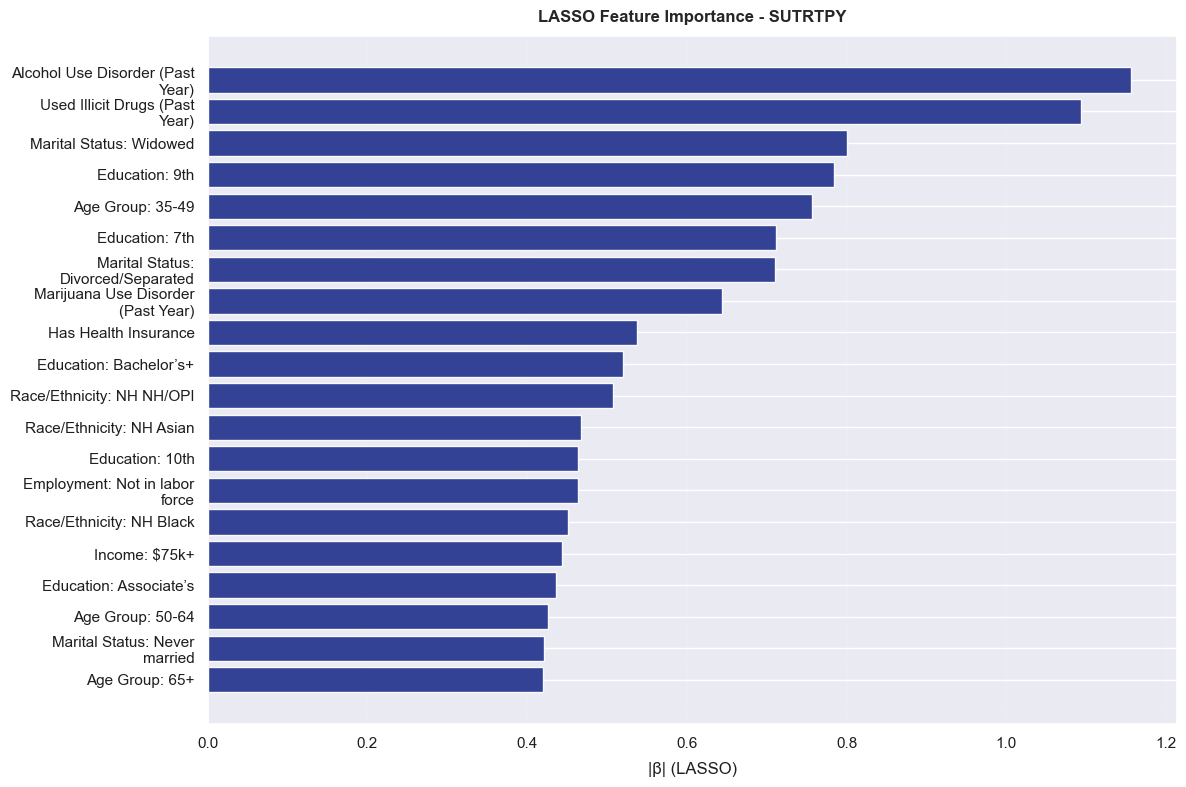

Saved: ../output_reports\SUTRTPY/lasso_output\lasso_SUTRTPY_feature_importance_pretty.png


In [15]:
plot_lasso_from_export_pretty("SUTRTPY", top_n=20)

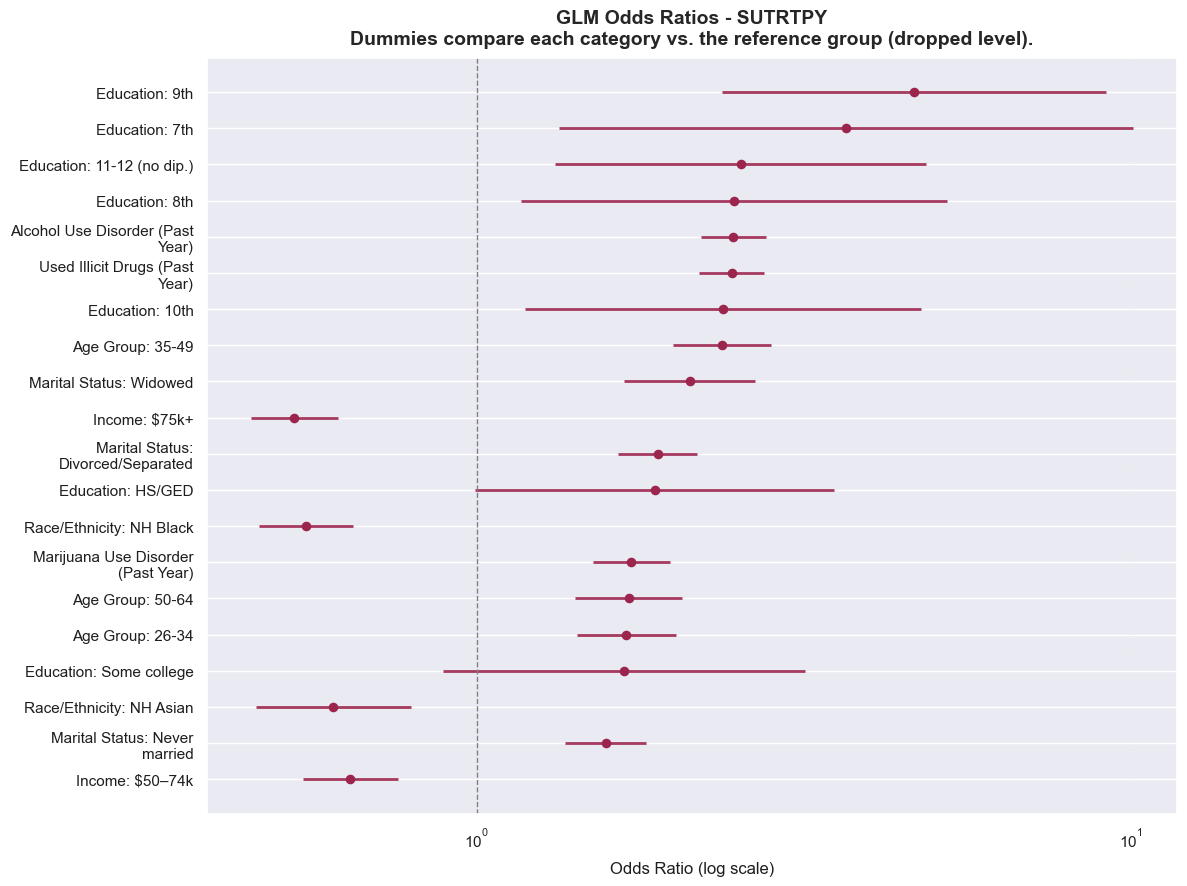

Saved: ../output_reports\SUTRTPY/glm_output\glm_SUTRTPY_forest_pretty.png


In [16]:
plot_glm_forest_from_export_pretty("SUTRTPY", top_n=20,
    ref_note="Dummies compare each category vs. the reference group (dropped level).")

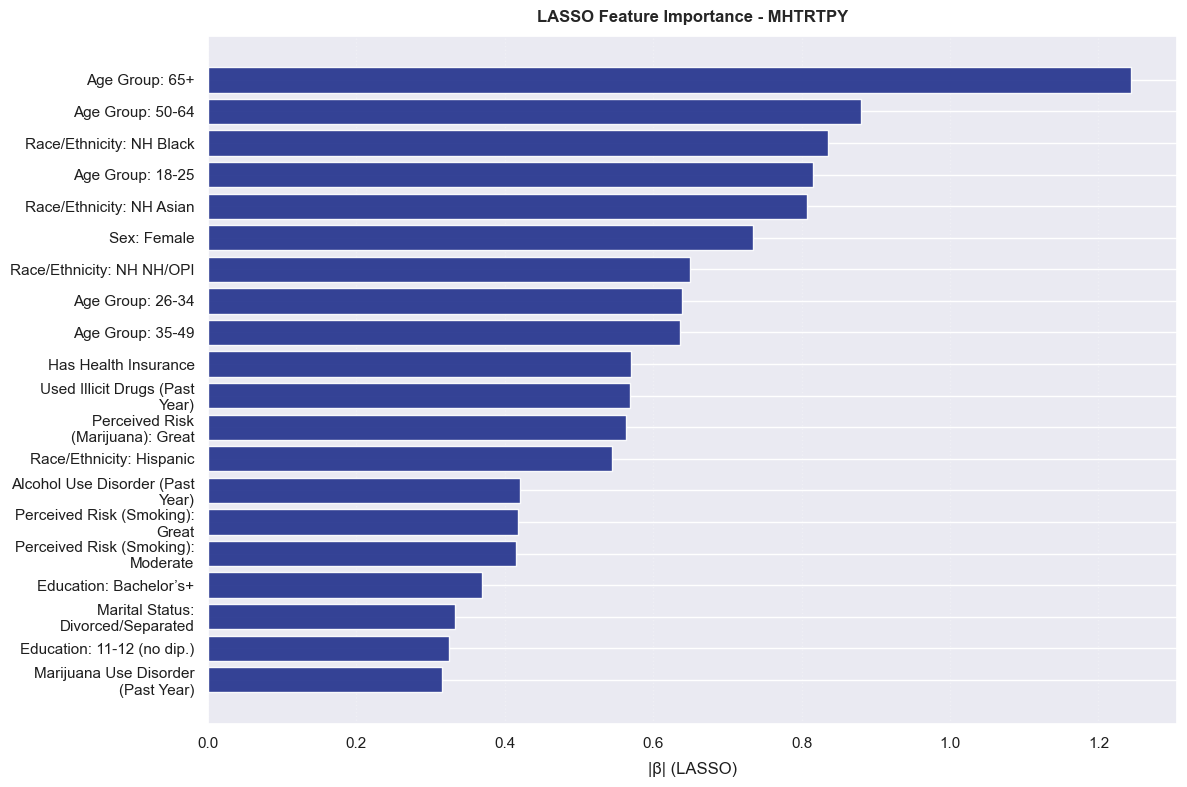

Saved: ../output_reports\MHTRTPY/lasso_output\lasso_MHTRTPY_feature_importance_pretty.png


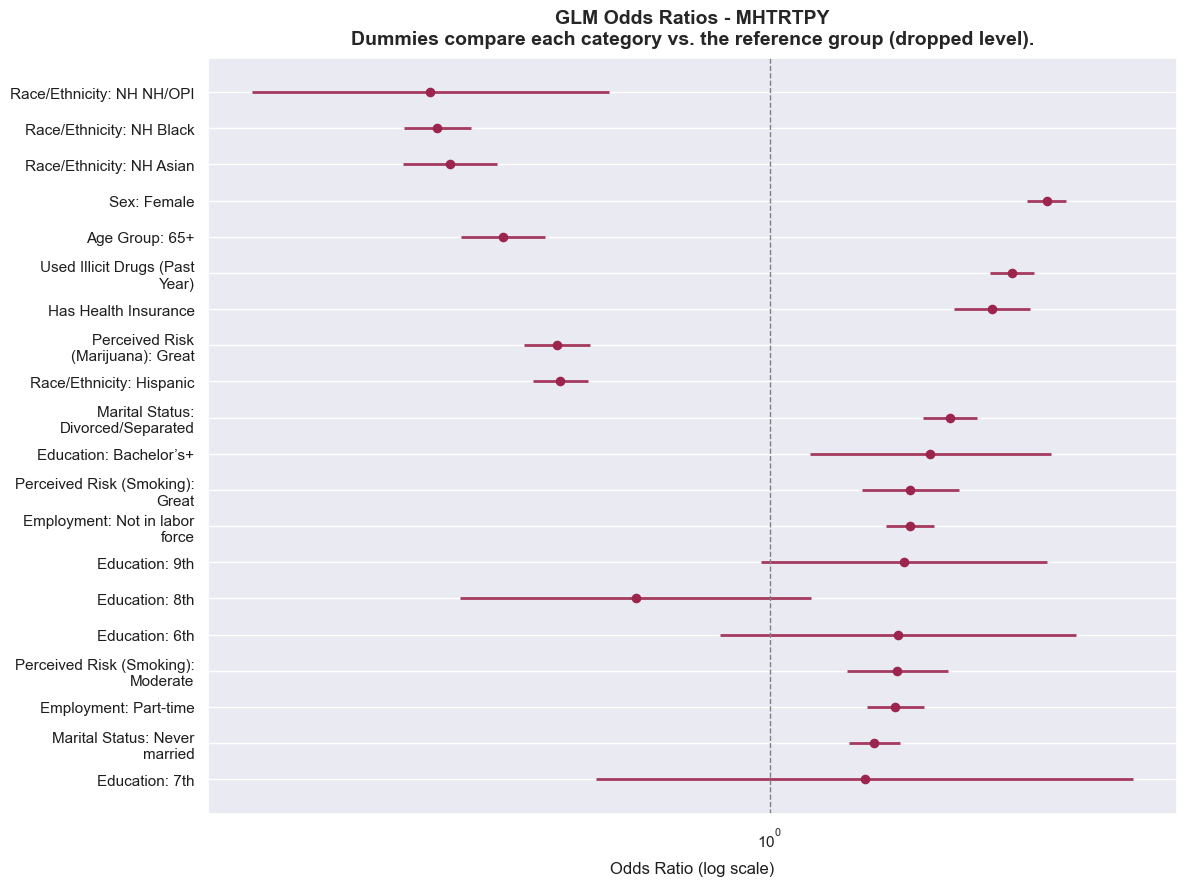

Saved: ../output_reports\MHTRTPY/glm_output\glm_MHTRTPY_forest_pretty.png


In [18]:
plot_lasso_from_export_pretty("MHTRTPY", top_n=20)
plot_glm_forest_from_export_pretty("MHTRTPY", top_n=20,
    ref_note="Dummies compare each category vs. the reference group (dropped level).")